In [8]:
import collections
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
tfb = tfp.bijectors

warnings.simplefilter('ignore')


In [9]:
def load_and_preprocess_radon_dataset(state='MN'):  
    """Preprocess Radon dataset as done in "Bayesian Data Analysis" book.

    We filter to Minnesota data (919 examples) and preprocess to obtain the
    following features:
    - `log_uranium_ppm`: Log of soil uranium measurements.
    - `county`: Name of county in which the measurement was taken.
    - `floor`: Floor of house (0 for basement, 1 for first floor) on which the
    measurement was taken.

    The target variable is `log_radon`, the log of the Radon measurement in the
    house.
    """
    ds = tfds.load('radon', split='train')
    radon_data = tfds.as_dataframe(ds)
    radon_data.rename(lambda s: s[9:] if s.startswith('feat') else s, axis=1, inplace=True)
    df = radon_data[radon_data.state==state.encode()].copy()

    # For any missing or invalid activity readings, we'll use a value of `0.1`.
    df['radon'] = df.activity.apply(lambda x: x if x > 0. else 0.1)
    # Make county names look nice. 
    df['county'] = df.county.apply(lambda s: s.decode()).str.strip().str.title()
    # Remap categories to start from 0 and end at max(category).
    county_name = sorted(df.county.unique())
    df['county'] = df.county.astype(
      pd.api.types.CategoricalDtype(categories=county_name)).cat.codes
    county_name = list(map(str.strip, county_name))

    df['log_radon'] = df['radon'].apply(np.log)
    df['log_uranium_ppm'] = df['Uppm'].apply(np.log)
    df = df[['idnum', 'log_radon', 'floor', 'county', 'log_uranium_ppm']]

    return df, county_name

In [10]:
radon, county_name = load_and_preprocess_radon_dataset()
num_counties = len(county_name)
num_observations = len(radon)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Bora\tensorflow_datasets\radon\1.0.0.incompleteST4RFL\radon-train.tfrecord*...:   0%|      …

Dataset radon downloaded and prepared to C:\Users\Bora\tensorflow_datasets\radon\1.0.0. Subsequent calls will reuse this data.


In [11]:
county = tf.convert_to_tensor(radon['county'], dtype=tf.int32)
floor = tf.convert_to_tensor(radon['floor'], dtype=tf.float32)
log_radon = tf.convert_to_tensor(radon['log_radon'], dtype=tf.float32)
log_uranium = tf.convert_to_tensor(radon['log_uranium_ppm'], dtype=tf.float32)

In [12]:
radon.head()

,idnum,log_radon,floor,county,log_uranium_ppm
8,5161,1.791759,0,6,0.271614
29,5926,2.501436,0,79,-0.147484
32,5793,-0.223144,0,69,-0.474674
39,5829,1.193922,0,69,-0.474674
60,5231,1.064711,0,17,-0.633391


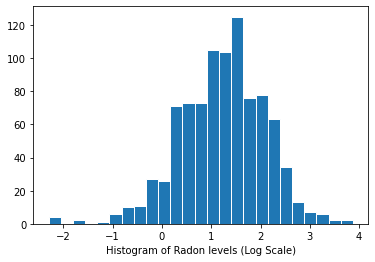

In [13]:
plt.hist(log_radon.numpy(), bins=25, edgecolor='white')
plt.xlabel("Histogram of Radon levels (Log Scale)")
plt.show()

## Complete pooling

In [14]:
@tf.function
def affine(x, kernel_diag, bias=tf.zeros([])):
    """`kernel_diag * x + bias` with broadcasting."""
    kernel_diag = tf.ones_like(x) * kernel_diag
    bias = tf.ones_like(x) * bias
    return x * kernel_diag + bias

In [15]:
def pooled_model(floor):
    """Creates a joint distribution representing our generative process."""
    return tfd.JointDistributionSequential([
      tfd.Normal(loc=0., scale=1e5),  # alpha
      tfd.Normal(loc=0., scale=1e5),  # beta
      tfd.HalfCauchy(loc=0., scale=5),  # sigma
      lambda s, b1, b0: tfd.MultivariateNormalDiag(  # y
          loc=affine(floor, b1[..., tf.newaxis], b0[..., tf.newaxis]),
          scale_identity_multiplier=s)
    ])


@tf.function
def pooled_log_prob(alpha, beta, sigma):
    """Computes `joint_log_prob` pinned at `log_radon`."""
    return pooled_model(floor).log_prob([alpha, beta, sigma, log_radon])


In [16]:
@tf.function
def sample_pooled(num_chains, num_results, num_burnin_steps, num_observations):
    """Samples from the pooled model."""
    hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=pooled_log_prob,
      num_leapfrog_steps=10,
      step_size=0.005)

    initial_state = [
      tf.zeros([num_chains], name='init_alpha'),
      tf.zeros([num_chains], name=/'init_beta'),
      tf.ones([num_chains], name='init_sigma')
    ]

    # Constrain `sigma` to the positive real axis. Other variables are
    # unconstrained.
    unconstraining_bijectors = [
      tfb.Identity(),  # alpha
      tfb.Identity(),  # beta
      tfb.Exp()        # sigma
    ]
    kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)

    samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

    acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

    return samples, acceptance_probs

In [17]:
PooledModel = collections.namedtuple('PooledModel', ['alpha', 'beta', 'sigma'])

samples, acceptance_probs = sample_pooled(
    num_chains=4,
    num_results=1000,
    num_burnin_steps=1000,
    num_observations=num_observations)

print('Acceptance Probabilities for each chain: ', acceptance_probs.numpy())
pooled_samples = PooledModel._make(samples)


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Acceptance Probabilities for each chain:  [0.994 0.991 0.994 0.994]
